In [1]:
input_dim = 13
num_clusters = 8

model_file = "../Heart/Model/model/perplexity_10_regularizer_0.001_batch_size_302_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt"

import csv
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

os.system("rm *.png")

import sys
sys.path.insert(0, "../Code/")
from explain_cs import explain
from load_scvis import load_vae
from metrics import metrics, eval_epsilon, similarity
from myplot import plot_polys, plot_groups, plot_metrics, plot_explanation
from misc import poly2labels, load

def load_model(input_dim = input_dim, model_file = model_file):
    return load_vae(input_dim, model_file)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
# Load Data & Configuration

x = pd.read_csv("../Heart/Data/X.tsv", sep="\t").values

y = pd.read_csv("../Heart/Data/y.tsv", sep="\t").values


with open("../Heart/vertices.json") as json_file:  
    all_vertices = json.load(json_file)


In [3]:
# Calculate Data Representation

sess, rep, X, D = load_model()

data_rep = sess.run(rep, feed_dict={X: x, D: np.zeros((1, input_dim))})




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



INFO:tensorflow:Restoring parameters from ../Heart/Model/model/perplexity_10_regularizer_0.001_batch_size_302_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


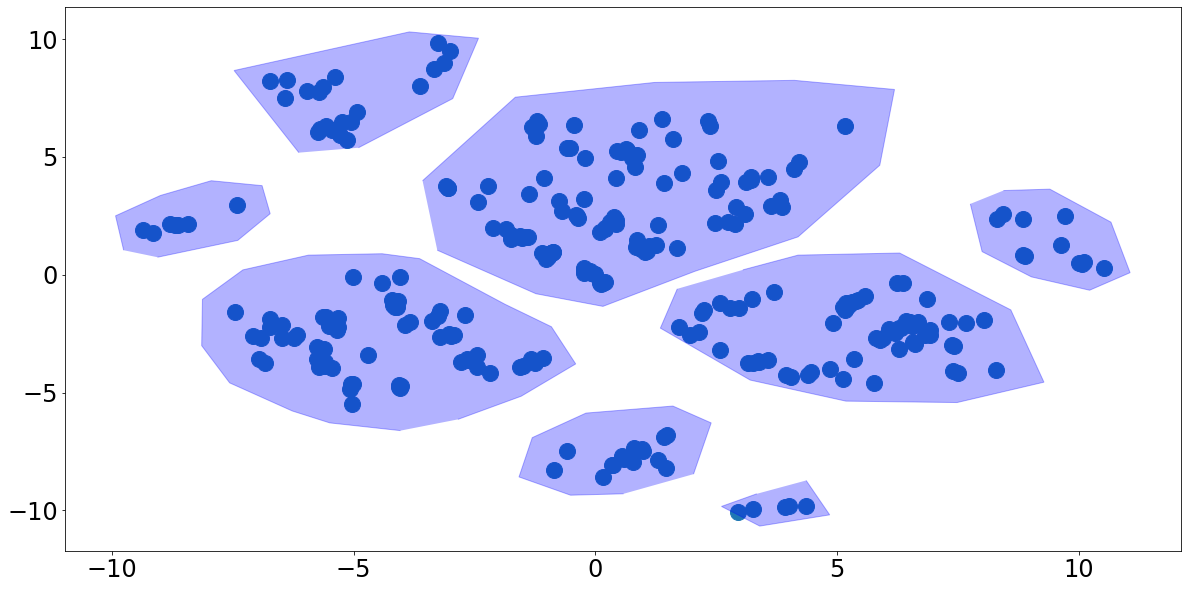

In [4]:
# Visualize the data and the marked clusters

plot_polys(data_rep, all_vertices)

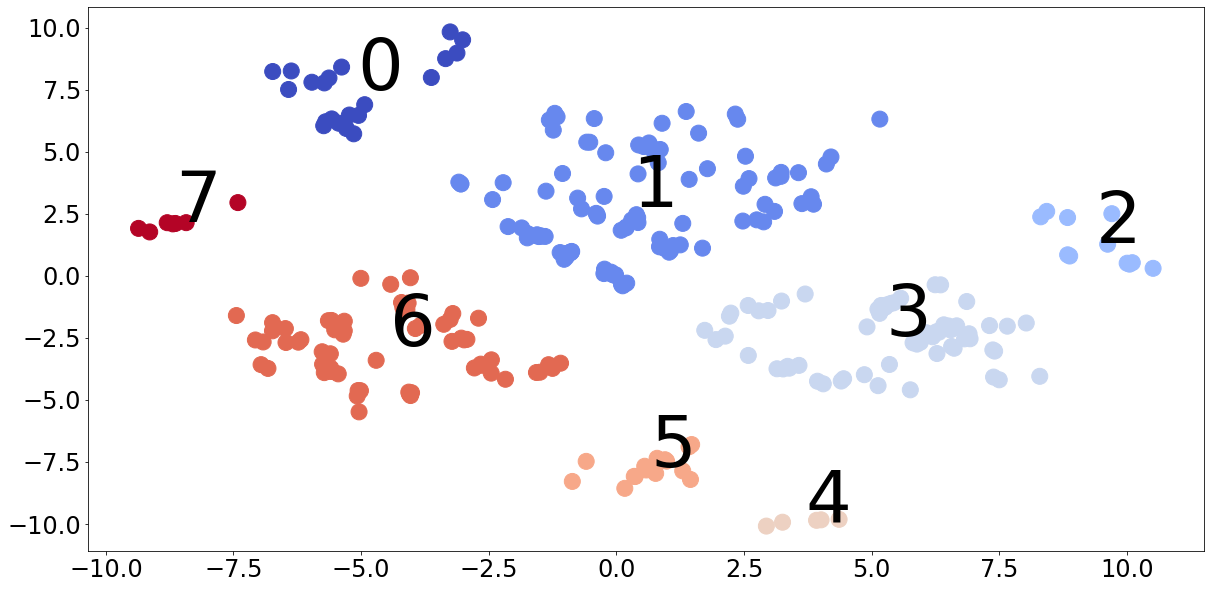

In [5]:
# Visualize the clusters in the learned representation

labels = poly2labels(data_rep, all_vertices)

means, centers, indices = plot_groups(x, data_rep, num_clusters, labels, name = "heart-rep.png")


In [6]:
# Set epsilon for our metrics

epsilon = 1.0

if True:
    os.system("rm epsilon.txt")
    eval_epsilon(load_model, x, indices, epsilon)


INFO:tensorflow:Restoring parameters from ../Heart/Model/model/perplexity_10_regularizer_0.001_batch_size_302_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


In [7]:
run = False

# Initialize results 
# Columns are:  K, TGT-correctness, TGT-coverage, DBM-correctness, DBM-coverage
K = [1, 3, 5, 7, 9, 11, 13]
if run:
    os.system("rm *.npy")
    os.system("rm out.csv")

    out = np.zeros((len(K), 5))

    c = 0
    for k in K:
        out[c, 0] = k
        c += 1

In [8]:
# Compute the group explanations at each of a range of sparsities

if run:

    c = 0
    for k in K:

        best_val = 0.0
        for lg in [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]:
            for trial in range(5):

                deltas = explain(load_model, means, centers, learning_rate = 0.01, consecutive_steps = 5, lambda_global = lg)
                a, b = metrics(load_model, x, indices, deltas, epsilon, k = k) 

                val = np.mean(a)

                if val > best_val:
                    best_val = val
                    out[c, 1] = best_val
                    out[c, 2] = np.mean(b)
                    np.save("deltas" + str(k) + ".npy", deltas)

                os.system("rm -rf explanation")

        c += 1
                    

In [9]:
# Evaluate DBM 

if run:
    exp_mean = np.zeros((num_clusters - 1, input_dim))
    for i in range(num_clusters - 1):
        exp_mean[i, :] = means[i + 1] - means[0]

    c = 0
    for k in K:
        a, b = metrics(load_model, x, indices, exp_mean, epsilon, k = k)

        out[c, 3] = np.mean(a)
        out[c, 4] = np.mean(b)

        c += 1
    

In [10]:
# Save results
if run:
    np.savetxt("out.csv", out, delimiter = ",")
else:
    out = np.loadtxt("out.csv", delimiter = ",")
    
print(out)

[[ 1.          0.46050071  0.46428628  0.44305419  0.46312005]
 [ 3.          0.88528802  0.85529544  0.88176218  0.86176404]
 [ 5.          0.9060832   0.85983117  0.90597469  0.86774243]
 [ 7.          0.91377861  0.84804054  0.90930335  0.85920251]
 [ 9.          0.91681428  0.85725429  0.91583736  0.86308478]
 [11.          0.90324837  0.85135773  0.91850353  0.86636325]
 [13.          0.90747808  0.8598646   0.91850353  0.86636325]]


In [11]:
# Evaluate the stability of TGT as it finds sparser explanations
# Warning:  check the order of the elements of K to ensure the correct comparison is being made
S = np.zeros((len(K) - 1, 2))

for c in range(len(K) - 1):
    k_more = K[c]
    k_less = K[c + 1]
    
    d_more = np.load("deltas" + str(k_more) + ".npy")
    d_less = np.load("deltas" + str(k_less) + ".npy")

    res = np.ones((num_clusters, num_clusters))
    for i in range(num_clusters):
        for j in range(num_clusters):
            if i != j:
                e_more = load(d_more, k_more, i, j)
                e_less = load(d_less, k_less, i, j)
                res[i, j] = similarity(e_more, e_less)
        
    S[c, 0] = k_more
    S[c, 1] = np.mean(res)



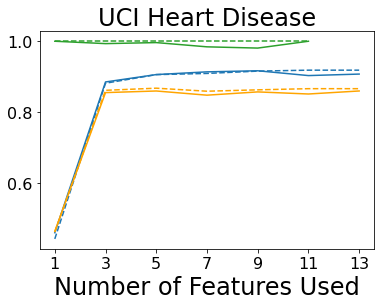

In [12]:
# Plot the comparison of TGT to DBM based on our metrics at varying degrees of sparsity

import matplotlib
matplotlib.rc("xtick", labelsize = 16)
matplotlib.rc("ytick", labelsize = 16)
matplotlib.rc("axes", titlesize = 24)
matplotlib.rc("axes", labelsize = 24)
#matplotlib.rc("lines", markersize = 16)

plt.plot(out[:, 0], out[:, 1], c = "C0", label = "Correctness - TGT")
plt.plot(out[:, 0], out[:, 3], ls = "--", c= "C0", label = "Correctness - DBM")
plt.plot(out[:, 0], out[:, 2], c = "orange", label = "Coverage - TGT")
plt.plot(out[:, 0], out[:, 4], ls = "--", color = "orange", label = "Coverage - DBM")
plt.plot(S[:, 0], S[:, 1], color = "C2", label = "Similarity - TGT")
plt.plot(S[:, 0], np.ones((len(K) - 1)), ls = "--", color = "C2", label = "Similarity - DBM")

#plt.ylabel("Metric")
plt.xlabel("Number of Features Used")
plt.xticks(np.arange(1, 15, step=2))
plt.title("UCI Heart Disease")

#plt.legend()

plt.savefig("heart-tradeoff.png", bbox_inches='tight')
plt.show()
plt.close()